In [1]:
import torch
from torch import nn
import numpy as np
from transformers import T5EncoderModel, T5Tokenizer
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import pytorch_lightning as pl
#from pytorch_lightning.plugins import DDPPlugin
from torch import nn
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import gzip
from numpy import dot
from numpy.linalg import norm
import seaborn as sns
import pickle

class GRU_CNN_Block(nn.Module):
    def __init__(self, input_size=1024, hidden_size=256, num_layers=1, out_dim=512, dropout=0.1, nheads=4):
        super(GRU_CNN_Block, self).__init__()
        base_filepath = "F:/Master/Research/"
        self.tokenizer = T5Tokenizer.from_pretrained(base_filepath + "data/prot_t5_xl_uniref50", do_lower_case=False)
        self.t5model = T5EncoderModel.from_pretrained(base_filepath + "data/prot_t5_xl_uniref50")
        self.t5model.eval()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.t5model.to(self.device)

        self.hidden_size = hidden_size

        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                           batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(input_size=hidden_size * 2, hidden_size=hidden_size, num_layers=num_layers,
                           batch_first=True, bidirectional=True)

        self.ln1 = nn.LayerNorm(hidden_size * 2)
        self.ln2 = nn.LayerNorm(hidden_size * 2)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.leaky_relu1 = nn.LeakyReLU()
        self.leaky_relu2 = nn.LeakyReLU()


        self.conv3 = nn.Conv1d(in_channels=hidden_size * 2, out_channels=hidden_size * 2, kernel_size=3, padding=1)
        self.conv7 = nn.Conv1d(in_channels=hidden_size * 2, out_channels=hidden_size * 2, kernel_size=7, padding=3)


        self.ln_conv = nn.LayerNorm(hidden_size * 2)
        self.dropout_conv = nn.Dropout(dropout)
        self.leaky_relu3 = nn.LeakyReLU()

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size*2, num_heads=nheads, dropout=dropout, batch_first=True)
        self.ln_attn = nn.LayerNorm(hidden_size * 2)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.mlp = nn.Linear(hidden_size * 2, out_dim)

        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.l1_loss = nn.L1Loss(reduction='mean')

    def featurize_prottrans(self, sequences):
        sequences = [(" ".join(seq)) for seq in sequences]
        sequences = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences]

        ids = self.tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding=True)
        input_ids = torch.tensor(ids['input_ids']).to(self.device)
        attention_mask = torch.tensor(ids['attention_mask']).to(self.device)

        with torch.no_grad():
            embedding = self.t5model(input_ids=input_ids, attention_mask=attention_mask)

        embedding = embedding.last_hidden_state.cpu().numpy()

        features = []
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][:seq_len - 1]
            features.append(seq_emd)

        max_len = max(feat.shape[0] for feat in features)
        features_padded = np.zeros((len(features), max_len, features[0].shape[1]))

        for i, feat in enumerate(features):
            features_padded[i, :feat.shape[0], :] = feat

        prottrans_embedding = torch.tensor(features_padded, dtype=torch.float32).to(self.device)
        return prottrans_embedding

    def forward(self, seq1, seq2):
        seq1_encoded = self.featurize_prottrans(seq1)
        seq2_encoded = self.featurize_prottrans(seq2)

        # 第一个GRU + LN + Dropout + 激活
        x1, _ = self.gru1(seq1_encoded)
        x1 = self.ln1(x1)
        x1 = self.dropout1(x1)
        x1 = self.leaky_relu1(x1)

        # 第二个GRU + LN + Dropout + 激活
        x1, _ = self.gru2(x1)
        x1 = self.ln2(x1)
        x1 = self.dropout2(x1)
        x1 = self.leaky_relu2(x1)

        # 简单的自注意力机制
        x1_attn, _ = self.attention(x1, x1, x1)  # Q=K=V=x1
        x1 = x1 + x1_attn  # 残差连接
        x1 = self.ln_attn(x1)

        # 卷积提取局部特征 + 残差连接
        residual = x1
        conv3_output = self.conv3(x1.transpose(1, 2)).transpose(1, 2)
        conv7_output = self.conv7(x1.transpose(1, 2)).transpose(1, 2)
        x1 = conv3_output + conv7_output
        x1 = self.ln_conv(x1)  
        x1 = self.dropout_conv(x1)
        x1 = self.leaky_relu3(x1)
        x1 = x1 + residual

        # 池化 + MLP映射
        x1 = self.pooling(x1.transpose(1, 2)).squeeze(2)
        x1 = self.mlp(x1)

        x2, _ = self.gru1(seq2_encoded)
        x2 = self.ln1(x2)
        x2 = self.dropout1(x2)
        x2 = self.leaky_relu1(x2)

        x2, _ = self.gru2(x2)
        x2 = self.ln2(x2)
        x2 = self.dropout2(x2)
        x2 = self.leaky_relu2(x2)

        x2_attn, _ = self.attention(x2, x2, x2)
        x2 = x2 + x2_attn
        x2 = self.ln_attn(x2)

        residual = x2
        conv3_output = self.conv3(x2.transpose(1, 2)).transpose(1, 2)
        conv7_output = self.conv7(x2.transpose(1, 2)).transpose(1, 2)
        x2 = conv3_output + conv7_output
        x2 = self.ln_conv(x2)
        x2 = self.dropout_conv(x2)
        x2 = self.leaky_relu3(x2)
        x2 = x2 + residual

        x2 = self.pooling(x2.transpose(1, 2)).squeeze(2)
        x2 = self.mlp(x2)

        return x1, x2

    def distance_loss(self, output_seq1, output_seq2, tm_score):
        dist_seq = self.cos(output_seq1, output_seq2)
        dist_tm = self.l1_loss(dist_seq.unsqueeze(0), tm_score.float().unsqueeze(0))
        return dist_tm

    def calculate_tm_score(self, seq1, seq2):
        output_seq1, output_seq2 = self.forward(seq1, seq2)
        similarity = self.cos(output_seq1, output_seq2)
        return similarity.mean().item()

In [2]:
model = GRU_CNN_Block()
model.load_state_dict(torch.load("C:/Users/admin/Desktop/pth/final_model.pth"))
model.eval()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
sequence_df = pd.read_csv("108.csv", header=None, names=['sequence1', 'sequence2', 'tm_max'])

Some weights of the model checkpoint at F:/Master/Research/data/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.17.layer.0.SelfAttention.k.weight', 'decoder.block.23.layer.0.SelfAttention.k.weight', 'decoder.block.12.layer.1.EncDecAttention.q.weight', 'decoder.block.22.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.23.layer.1.EncDecAttention.k.weight', 'decoder.block.7.layer.0.layer_norm.weight', 'decoder.block.10.layer.0.SelfAttention.k.weight', 'decoder.block.7.layer.0.SelfAttention.o.weight', 'decoder.block.14.layer.1.EncDecAttention.k.weight', 'decoder.block.3.layer.2.DenseReluDense.wo.weight', 'decoder.block.15.layer.2.DenseReluDense.wo.weight', 'decoder.block.20.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.0.SelfAttention.k.weight', 'decoder.block.8.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.2.DenseReluDense.wi.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 

In [3]:
import time
tm_score_predictions = []
differences = 0.0

for i in range(sequence_df.shape[0]):
    sequence_1 = sequence_df.loc[i, 'sequence1']
    sequence_2 = sequence_df.loc[i, 'sequence2']
    actual_tm_score = sequence_df.loc[i, 'tm_max']

    print(sequence_1, " ", sequence_2)

    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)


    predicted_tm_score = model.calculate_tm_score(sequence_1, sequence_2)
    
    difference = abs(predicted_tm_score - actual_tm_score)
    print(f"Predicted TM-score: {predicted_tm_score}, Actual TM-score: {actual_tm_score}, Difference: {difference}")
    
    differences += difference
    
    tm_score_predictions.append(predicted_tm_score)

differences = differences / 1000

DGFSSIKDIAKRKHDLIAKTYEDLKKLEEKCNEEEKEFIKQKIKGIERXKKISEKILEALNDLDN   KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSAK
Predicted TM-score: 0.5070332288742065, Actual TM-score: 0.51739, Difference: 0.010356771125793474
AKTTPPSVYPLAPGCGDTTGSSVTLGCLVKGYFPESVTVTWNSGSLSSSVHTFPALLQSGLYTMSSSVTVPSSTWPSQTVTCSVAHPASSTTVDKK   RERPEVRVWGKEADGILTLSCRAHGFYPRPIVVSWLKDGAVRGQDAHSGGIVPNGDGTYHTWVTIEAQPGDGDKYQCRVEHASLPQPGLY
Predicted TM-score: 0.7984983921051025, Actual TM-score: 0.75201, Difference: 0.04648839210510258
MEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGG   MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRG
Predicted TM-score: 0.8380120992660522, Actual TM-score: 0.76195, Difference: 0.07606209926605223
PHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA   MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKLARHAGRKTIKAEDIELAVRRFKK
Predicted TM-score

Predicted TM-score: 0.4030163884162903, Actual TM-score: 0.47006, Difference: 0.0670436115837097
GSMDALNSKEQQEFQKVVEQKQMKDFMRLYSNLVERCFTDCVNDFTTSKLTNKEQTCIMKCSEKFLKHSERVGQRFQEQNAALGQGLGR   MMSGAPSATQPATAETQHIADQVRSQLEEKYNKKFPVFKAVSFKSQVVAGTNYFIKVHVGDEDFVHLRVFQSLPHENKSLTLSNYQTNKAKHDELTYF
Predicted TM-score: 0.3745400905609131, Actual TM-score: 0.3037, Difference: 0.07084009056091306
MVLVQDLLHPTAASEARKHKLKTLVQSPRSHFLDVKCPGCLNITTVFSHAQTAVTCESCSTVLCTPTGGKAKLSEGTSFRRK   TAVCMECFREAAYSKRLGTEKEVEVIGGADKYHSVCRLCYFKKA
Predicted TM-score: 0.38579702377319336, Actual TM-score: 0.17434, Difference: 0.21145702377319336
SMGVLMVGPNFRVGKKIGCGNFGELRLGKNLYTNEYVAIKLEPMKSRAPQLHLEYRFYKQLGSGDGIPQVYYFGPCGKYNAMVLELL   TEVDPTHFEKRFLKRIRDLGEGHFGKVELCRYDPEGDNTGEQVAVKSLKPESGGNHIADLKKEIEILRNLYHENIVKYKGICTEDGGNGIKLIMEF
Predicted TM-score: 0.6267433166503906, Actual TM-score: 0.67788, Difference: 0.05113668334960941
KSLDSWASLILQWFEDSGKLNQVITLYELSEGDETVNWEFHRMPESLLYYCLKPLCDRNRATMLKDENDKVIAIKVV   MSKKTIVSMAVIRRLPRYHRY

Predicted TM-score: 0.5612757205963135, Actual TM-score: 0.50724, Difference: 0.05403572059631345
MEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGG   AEGDDPAKAAFNSLQASATEYIGYAWAMVVVIVGATIGIKLFKKFTSKAS
Predicted TM-score: 0.1401866376399994, Actual TM-score: 0.19237, Difference: 0.052183362360000624
LPYQCPKNGTAVCATNRRSFPTYCQQKSLECLHPGTKFLNNGTCTAEG   DQTFYPNHKEMLSSTTYPVVVKMGHAHSGMGKVKVDNQHDFQDIASVVALTKTYATAEPF
Predicted TM-score: 0.3321385085582733, Actual TM-score: 0.40278, Difference: 0.07064149144172671
GAMDTLYAILDEKKSELLQRITQEQEEKLSFIEALIQQYQEQLDKSTKLVETAIQSLDEPG   SRKESYSIYVYKVLKQVHPDTGISSKAMGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSAK
Predicted TM-score: 0.5879705548286438, Actual TM-score: 0.52958, Difference: 0.05839055482864375
TFTVRIVTMDAEMEFNCEMKWKGKDLFDLVCRTLGLRETWFFGLQYTIKDTVAWLKMDKKVLDHDVSKEEPVTFHFLA   MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG
Predicted TM-score: 0.789909839630127, Actual

Predicted TM-score: 0.34897610545158386, Actual TM-score: 0.34526, Difference: 0.003716105451583851
MPRLKVKLVKSPIGYPKDQKAALKALGLRRLQQERVLEDTPAIRGNVEKVAHLVRVEVVE   MPRLKVKLVKSPIGYPKDQKAALKALGLRRLQQERVLEDTPAIRGNVEKVAHLVRVEVVE
Predicted TM-score: 1.0, Actual TM-score: 0.97803, Difference: 0.021970000000000045
TLPLAKIPGVGKVSAAKLEAMGLRTCGDVQKCDLVMLLKRFGKFGRILWERSQGI   RTGFFAHAGFCLEHASCPPGAGVIAPGTPSQNTQCQPCPPGTFSASSSSSEQCQPHRNCTALGLALNVPGSSSHDTLCTSTGHHHHHH
Predicted TM-score: 0.22534015774726868, Actual TM-score: 0.21306, Difference: 0.012280157747268677
PHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA   MGELPIAPIGRIIKNAGAERVSDDARIALAKVLEEMGEEIASEAVKLAKHAGRKTIKAEDIELARKMFK
Predicted TM-score: 0.6780747175216675, Actual TM-score: 0.60193, Difference: 0.07614471752166752
SHEQFRAALQLVVDPGDPRSYLDNFIKIGEGSTGIVCIATVRSSGKLVAVKKMDLRKQQRRELLFNEVVIMRDYQHENVVEMYNSYLVGDELWVVMEF   LEYDYEYDENGDRVVLGKGTYGIVYAGRDLSNQVRIAIKEIPERDSRYSQPLHEEIALHKHLKHKNIVQYLGSFS

Predicted TM-score: 0.9176270961761475, Actual TM-score: 0.91347, Difference: 0.004157096176147457
SHTDIKVPDFSDYRRPEVLDSTKSSKESSEARKGFSYLVTATTTVGVAYAAKNVVSQFVSSMSA   GSHMAPADYFRVLVQQFEVQLQQYRQQIEELENHLATQANNSHITPQDLSMAMQKIYQTFVALAAQLQSIHENVKVLKEQYLSYRKMFLGDAG
Predicted TM-score: 0.5779167413711548, Actual TM-score: 0.54145, Difference: 0.0364667413711548
VPVLWNIRIKYNLLERVVGAKEMLKVDPIRAKETLMLSVGSSTTLGIVTSVKKDEIEVELRRPVAVWSNNIRTVISRQIAGRWRMIGWGLVEI   MYSRADRLLRQFSLKLNTDSIVF
Predicted TM-score: 0.1275235116481781, Actual TM-score: 0.0978, Difference: 0.029723511648178103
ERKAEAERLKEILENLTLTIPVRAGETKIYGSVTAKDIAEALSRQHGVTIDPKRLALEKPIKELGEYVLTYKPHPEVPIQLKVSVVAQE   GNAEHMLRVLGKAGAARWRGVRPTVRGTAMNPVDHPHGGGEGRNFGKHPVTPWGVQTKGKKTRSNKRTDKFIVRRRS
Predicted TM-score: 0.18425288796424866, Actual TM-score: 0.18618, Difference: 0.001927112035751355
GDHFQAFIDSQVADGRYGSASEVIRAGLRLLEENEAKLAALRAALIEGEESGFIEDFDFDAFIEERSRASAPQGFHEE   EEIVPLFQVAWNDAANPDKGFQYLYLTSEGMETLKKFDKENSVLTERTVINGEERFVIKTIIGSED
Predict

Predicted TM-score: 0.6301706433296204, Actual TM-score: 0.64382, Difference: 0.013649356670379587
TFTVRIVTMDAEMEFNCEMKWKGKDLFDLVCRTLGLRETWFFGLQYTIKDTVAWLKMDKKVLDHDVSKEEPVTFHFLA   EDNWAEDNPNDESKIAVLVVIYDHHQRELNQRMIDIQHASGTHVLSTTHIHMDEHNCLETIILQGNSFEIQRLQLEIGGLRGVKFAKLTKASSFEYNE
Predicted TM-score: 0.3038022220134735, Actual TM-score: 0.28651, Difference: 0.017292222013473524
WEYGMEVFYSHFPMQVNVEGDEVVIENFLGEKAPRRTTIHGDTDVEIDGEELTVSGPDIEAVGQTAADIEQLTRINDKDVRVFQDGVYITRKPNRGDA   MSRIGRLPIPVPKGVSVEVAPGRVKVKGPKGELEVPVSPEMRVVVEEGVVRVERPSDERRHKSLHGLTRTLIANAVKGVSEG
Predicted TM-score: 0.6474395990371704, Actual TM-score: 0.63154, Difference: 0.01589959903717042
MKRTWQPNRRKRAKTHGFRARMRTPGGRKVLKRRRQKGRWRLTPAVRKR   ALLRQAYSALFRRTSTFALTVVLGAVLFERAFDQGADAIFEHLNEGKLWKHIKHKYEASEE
Predicted TM-score: 0.2970527112483978, Actual TM-score: 0.38606, Difference: 0.08900728875160219
MVRDAYIAKNYNCVYECFRDAYCNELCTKNGASSGYCQWAGKYGNACWCYALPDNVPIRVPGKCR   ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVADGVYETSFFVNR

Predicted TM-score: 0.09569358825683594, Actual TM-score: 0.07961, Difference: 0.016083588256835937
VPVLWNIRIKYNLLERVVGAKEMLKVDPIRAKETLMLSVGSSTTLGIVTSVKKDEIEVELRRPVAVWSNNIRTVISRQIAGRWRMIGWGLVEI   DVIDRTKRTLRKRM
Predicted TM-score: 0.13989271223545074, Actual TM-score: 0.09304, Difference: 0.04685271223545075
DGFSSIKDIAKRKHDLIAKTYEDLKKLEEKCNEEEKEFIKQKIKGIERXKKISEKILEALNDLDN   MAKLGIHSNDTRDAWVNKIAQLNTLEKAAEMLKQFRMDHTTPFRNSYELDNDYLWIEAKLEEKVAVLKARA
Predicted TM-score: 0.47636717557907104, Actual TM-score: 0.54003, Difference: 0.06366282442092897
ETAPPNFVQRLQSMTVRQGSQVRLQVRVTGIPTPVVKFYRDGAEIQSSLDFQISQEGDLYSLLIAEAYPEDSGTYSVNATNSVGRATSTAELLVQ   IQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM
Predicted TM-score: 0.6268497109413147, Actual TM-score: 0.65638, Difference: 0.029530289058685266
SHTDIKVPDFSDYRRPEVLDSTKSSKESSEARKGFSYLVTATTTVGVAYAAKNVVSQFVSSMSA   XCGGRIARLEEKVKTLKAQNSELASTANMLREQVAQLKQKVMNY
Predicted TM-score: 0.7023218870162964, Ac

Predicted TM-score: 0.9961380958557129, Actual TM-score: 0.98947, Difference: 0.00666809585571293
VAKKRSRKTVKAQRPITGASLDLIKERRSLKPEVRKANREEKLKANKEKKKAEKAARKAEKAKSAGTQS   NAQIMQLHHSKHHAAYVNNLNVTEEKYQEALAKGDVTAQIALQPALKFNGGGHINHSIFWTNLS
Predicted TM-score: 0.41626182198524475, Actual TM-score: 0.41725, Difference: 0.0009881780147552588
GAMDTLYAILDEKKSELLQRITQEQEEKLSFIEALIQQYQEQLDKSTKLVETAIQSLDEPG   MTEETITIDSISNGILNNLLTTLIQDIVARETTQQQLLKTRYPDL
Predicted TM-score: 0.789888322353363, Actual TM-score: 0.59286, Difference: 0.19702832235336298
ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVTDGVYETSFLVNRDHSFHKLSYLTFIPSDDDIYDCKVEHWGLEEPVLKHWEPE   TYEEAIARLMATMKEASA
Predicted TM-score: 0.12098182737827301, Actual TM-score: 0.08924, Difference: 0.03174182737827301
ALESRQIGPRTLVWSEKEQVEKSAYEFSETESMLKIAEDLGGPYVWGQYDLLVLPPSFPYGGMENPCLTFVTPTLLAGDKSLSNVIAHEISHSWTGN   WLSEARKPF
Predicted TM-score: 0.17595727741718292, Actual TM-score: 0.08669, Difference: 0.08926727741718292
RYIQNLVTKNFPNKFDSENKVIQFQVS

Predicted TM-score: 0.6213113069534302, Actual TM-score: 0.63714, Difference: 0.015828693046569864
ANPCCSNPCQNRGECMSTGFDQYKCDCTRTGFYGENCTTPE   FQSMYQLFEELGKGAFSVVRRCVKVLAGQEYAAKIINTKKLSARDHQKLEREARICRLLKHPNIVRLHDSISEEGHHYLIFDL
Predicted TM-score: 0.3254677653312683, Actual TM-score: 0.35829, Difference: 0.03282223466873169
GAMDTLYAILDEKKSELLQRITQEQEEKLSFIEALIQQYQEQLDKSTKLVETAIQSLDEPG   VLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG
Predicted TM-score: 0.5658493638038635, Actual TM-score: 0.4552, Difference: 0.11064936380386353
GAMDTLYAILDEKKSELLQRITQEQEEKLSFIEALIQQYQEQLDKSTKLVETAIQSLDEPG   MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM
Predicted TM-score: 0.1267140507698059, Actual TM-score: 0.1906, Difference: 0.06388594923019408
AKTTPPSVYPLAPGCGDTTGSSVTLGCLVKGYFPESVTVTWNSGSLSSSVHTFPALLQSGLYTMSSSVTVPSSTWPSQTVTCSVAHPASSTTVDKK   AKTTPPSVYPLAPGSAAQTNSMVTLGCLVKGYFPEPVTVTWNSGSLSSGVHTFPAVLQSDLYTLSSSVTV

Predicted TM-score: 0.4757153391838074, Actual TM-score: 0.43691, Difference: 0.03880533918380735
LYSFFNSSTSYRVRIALALKGLDYQVVPVNLRQGEQLRPADRQRNPMGALPTLVDADGRRFSQSLAIIDYLDAVQPEP   PNYKLTYFNMRGRAEIIRYIFAYLDIQYEDHRIEQADWPEIKSTLPFGKIPILEVDGLTLHQSLAIARYLTKNTIPAVANWIKRRPQTKL
Predicted TM-score: 0.6598966121673584, Actual TM-score: 0.7295, Difference: 0.06960338783264164
SHTDIKVPDFSDYRRPEVLDSTKSSKESSEARKGFSYLVTATTTVGVAYAAKNVVSQFVSSMSA   VHNDVTVPDFSAYRREDVMDATTSSQTSSEDRKGFSYLVTATACVATAYAAKNVVTQFISSLSA
Predicted TM-score: 0.9517079591751099, Actual TM-score: 0.97474, Difference: 0.023032040824890188
DYKDPRRTELMVSMGYTREEIQDSLVGQRYNEVMATYLLLGYK   FHLDVEDYLSGVLILASELSRLSVNSVTAGDYSRPLHISTFINELDSGFRLLNLKNDSLRKRYDGLKYDVKKVEEVVYDLSIRGFNKETAAACVEK
Predicted TM-score: 0.21370002627372742, Actual TM-score: 0.3494, Difference: 0.13569997372627257
SHTDIKVPDFSDYRRPEVLDSTKSSKESSEARKGFSYLVTATTTVGVAYAAKNVVSQFVSSMSA   GSHMAPADYFRVLVQQFEVQLQQYRQQIEELENHLATQANNSHITPQDLSMAMQKIYQTFVALAAQLQSIHENVKVLKEQYLSYRKMFLGDAG


Predicted TM-score: 0.7767666578292847, Actual TM-score: 0.7646, Difference: 0.012166657829284722
ELGKQLAKKIEPELEGSSAVTSHDSSTNGLISFIKQQRDTK   WEYGMEVFYSHFPMQVNVEGDEVVIENFLGEKAPRRTTIHGDTDVEIDGEELTVSGPDIEAVGQTAADIEQLTRINDKDVRVFQDGVYITRKPNRGDA
Predicted TM-score: 0.3861970901489258, Actual TM-score: 0.52032, Difference: 0.13412290985107422
NVDDYYDTGEELGSGQFAVVKKCREKSTGLQYAAKFIKKRRTKSSRRGVSREDIEREVSILKEIQHPNVITLHEVYENKTDVILILELVAG   MATITCTRFTEEYQLFEELGKGAFSVVRRCVKVLAGQEYAAMIINTKKLSARDHQKLEREARICRLLKHPNIVRLHDSISEEGHHYLIFDL
Predicted TM-score: 0.8014528751373291, Actual TM-score: 0.86177, Difference: 0.060317124862670934
QLGIPHPAGLKKKKSVTVLDVGDAYPAIFQSSMTKILEPFAAQNPDIVICQYMDDLYVGSDLEIGQHRTKIEELRQHLLRWGLTTPDKKHQKEP   GSMQNTTHDNVILELTVRNHPGVMTHVCGLFARRAFNVEGILCLPIQDSDKSHIWLLVNDDQRLEQMISQIDKLEDVVKVQRNQSDPTMFNKIAVFFQ
Predicted TM-score: 0.5246630907058716, Actual TM-score: 0.5189, Difference: 0.005763090705871554
SHTDIKVPDFSDYRRPEVLDSTKSSKESSEARKGFSYLVTATTTVGVAYAAKNVVSQFVSSMSA   MTILFQLALAALVIL

Predicted TM-score: 0.10877103358507156, Actual TM-score: 0.16032, Difference: 0.05154896641492843
NVDDYYDTGEELGSGQFAVVKKCREKSTGLQYAAKFIKKRRTKSSRRGVSREDIEREVSILKEIQHPNVITLHEVYENKTDVILILELVAG   KVYNDGYDDDNYDYIVKNGEKWMDRYEIDSLIGKGSFGQVVKAYDRVEQEWVAIKIIKNKKAFLNQAQIEVRLLELMNKHDVHLKRHFMFRNHLCLVFEM
Predicted TM-score: 0.741264820098877, Actual TM-score: 0.75767, Difference: 0.016405179901123
MPRSLKKGVFVDDHLLEKVLELNAKGEKRLIKTWSRRSTIVPEMVGHTIAVYNGKQHVPVYITENMVGHKLGEFAPTRTYRGHGKEAKATKKK   YQPKDLRAKKTRALRRALTKFEASQVTEKQRKKQIAFPQRKYAIKA
Predicted TM-score: 0.10520178079605103, Actual TM-score: 0.19946, Difference: 0.09425821920394897
MPRSLKKGVFVDDHLLEKVLELNAKGEKRLIKTWSRRSTIVPEMVGHTIAVYNGKQHVPVYITENMVGHKLGEFAPTRTYRGHGKEAKATKKK   CSFESLVDQRIKEALSRQ
Predicted TM-score: 0.19181497395038605, Actual TM-score: 0.16667, Difference: 0.025144973950386035
MVLVQDLLHPTAASEARKHKLKTLVQSPRSHFLDVKCPGCLNITTVFSHAQTAVTCESCSTVLCTPTGGKAKLSEGTSFRRK   EQRQQIIGGQKAKMGNFPW
Predicted TM-score: 0.19935117661952972, Actual T

Predicted TM-score: 0.6124787330627441, Actual TM-score: 0.66212, Difference: 0.0496412669372559
ANPCCSNPCQNRGECMSTGFDQYKCDCTRTGFYGENCTTPE   NPCCSHPCQNRGVCMSVGFDQYKCDCTRTGFYGENCSTPE
Predicted TM-score: 0.9824461936950684, Actual TM-score: 0.95856, Difference: 0.023886193695068392
FVSVAVFVCKDCGHEMIVPQKPYESLEKVKKCEQCGSKNIELDVNKSSFV   DKFTPLPEGKLKEEIEVMAKSIDFPLTKVYVVEGSKRSSHSNAYFYGFFKNKRIVLFDTLLEQGCKNEEVLAVLGHELGHWKLG
Predicted TM-score: 0.26652371883392334, Actual TM-score: 0.30999, Difference: 0.04346628116607665
MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM   GGPFLDSFKKRIKRILSEN
Predicted TM-score: 0.1587923765182495, Actual TM-score: 0.03991, Difference: 0.11888237651824951
MSRIGRLPIPVPKGVSVEVAPGRVKVKGPKGELEVPVSPEMRVVVEEGVVRVERPSDERRHKSLHGLTRTLIANAVKGVSEG   QLGIPHPAGLKKKKSVTVLDVGDAYPAIFQSSMTKILEPFRKQNPDIVIYQYMDDLYVGSDLEIGQHRTKIEELRQHLLRWGLTTPDKKHQKEP
Predicted TM-score: 0.4507898986339569, Actual TM-score: 0.50773, Difference: 0.0

Predicted TM-score: 0.7651091814041138, Actual TM-score: 0.80912, Difference: 0.04401081859588618
WEYGMEVFYSHFPMQVNVEGDEVVIENFLGEKAPRRTTIHGDTDVEIDGEELTVSGPDIEAVGQTAADIEQLTRINDKDVRVFQDGVYITRKPNRGDA   YSKELLIKGIGYRARLVGRALELTVGFSHPVVVEPPEGITFEVPEPTRVRVSGIDKQKVGQVAANIRAIRKPSAYHEKGIYYAGEPVRLKPGKAGAKK
Predicted TM-score: 0.7131812572479248, Actual TM-score: 0.69503, Difference: 0.018151257247924768
MADDDAFVHLLRLKDTMTPWALRAVVTLGVPDLVAEGEKDVSELAQRSGAVPDALRRVLRLLARRGVFTEPRPAVFGPTGLSRLLQSDHPRSMRPWLDL   PLTFAQSFPANVSYNEYMDPVWVTAAIPESIAWLVKDASQFTLTVPARPDKTLTIRKWTLLPGVDAATRTLQLRLEVDNADEALKPGMNAWLQLNTASEP
Predicted TM-score: 0.29339367151260376, Actual TM-score: 0.2774, Difference: 0.01599367151260378
DGFSSIKDIAKRKHDLIAKTYEDLKKLEEKCNEEEKEFIKQKIKGIERXKKISEKILEALNDLDN   MQLVLAAKYIGAGISTIGLLGAGIGIAIVFAALINGVSRNPSIKDTVFPMAILGFALSEATGLFCLMVSFLLLFGV
Predicted TM-score: 0.4720328748226166, Actual TM-score: 0.58414, Difference: 0.11210712517738342
MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSK

Predicted TM-score: 0.3629911541938782, Actual TM-score: 0.37738, Difference: 0.01438884580612182
NVDDYYDTGEELGSGQFAVVKKCREKSTGLQYAAKFIKKRRTKSSRRGVSREDIEREVSILKEIQHPNVITLHEVYENKTDVILILELVAG   GMEPFKQQKVEDFYDIGEELGSGQFAIVKKCREKSTGLEYAAKFIKKRQSRASRRGVSREEIEREVSILRQVLHHNVITLHDVYENRTDVVLILELVS
Predicted TM-score: 0.961488664150238, Actual TM-score: 0.95622, Difference: 0.005268664150238078
EVPIRHPKFDWFKDLGLKWYGLPYMGTEIGVRDYCDNSRYNILEEVAKKMDLDMRKTSSLWKDQALVEINIAVLYSFQSDKVTIVDHHS   EVPIRHPKFDWFKDLGLKWYGLPYMGTEIGVRDYCDNSRYNILEEVAKKMDLDMRKTSSLWKDQALVEINIAVLYSFQSDKVTIVDHHS
Predicted TM-score: 1.0, Actual TM-score: 0.99383, Difference: 0.006170000000000009
MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM   MIQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHDSMAEPKTVYWDRDM
Predicted TM-score: 0.9811321496963501, Actual TM-score: 0.95375, Difference: 0.02738214969635011
SHEQFRAALQLVVDPGDPRSYLDNFIKIGEGSTGIVCIATVRS

Predicted TM-score: 0.36865752935409546, Actual TM-score: 0.35338, Difference: 0.015277529354095432
EVPIRHPKFDWFKDLGLKWYGLPYMGTEIGVRDYCDNSRYNILEEVAKKMDLDMRKTSSLWKDQALVEINIAVLYSFQSDKVTIVDHHS   EVPLEHPTLEWFAALGLRWYALPYMSTEIGTRNLCDPHRYNILEDVAVCMDLDTRTTSSLWKDKAAVEINLAVLHSFQLAKVTIVDHHA
Predicted TM-score: 0.9920926690101624, Actual TM-score: 0.98986, Difference: 0.0022326690101623914
GAMDTLYAILDEKKSELLQRITQEQEEKLSFIEALIQQYQEQLDKSTKLVETAIQSLDEPG   VENVTESKELERLKRIDRMKTEFIANISHELRTPLTAIKAYAETIYNSLGELDLSTLKEFLEVIIDQSNHLENLLNELLDFSRLERKSLQ
Predicted TM-score: 0.6674726009368896, Actual TM-score: 0.71454, Difference: 0.047067399063110305
RYIQNLVTKNFPNKFDSENKVIQFQVSWSKISTAIFGDCKNGVFNKDYDFGFGKVRQAKDLQMGLLKYLGRPK   VGVSAEIAPGNTLPLAEIPEGVPVCNVESSPGDGGKFARASGVNAQLLTHDRNVAVVKLPSGEMKRLDPQCRATIGVV
Predicted TM-score: 0.2799127995967865, Actual TM-score: 0.28075, Difference: 0.0008372004032135005
ANPCCSNPCQNRGECMSTGFDQYKCDCTRTGFYGENCTTPE   TCNIKNGRCEQFCKNSADNKVVCSCTEGYRLAENQKSCEPAVPFPCGRVSVSQTSKLTR
Predi

Predicted TM-score: 0.20550405979156494, Actual TM-score: 0.19763, Difference: 0.007874059791564941
MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLAEAFVTAALLGQQALPADAARLVGAKLDLDEDSILLLQMIPLRGCIDDRI   GLDWTDEFLMKVSEISGQPIPASLTKERGRLVDMMTDSHTWLHGLGYEGAMQILTTLVNSILERLDEETRGMQATDYNHDLVR
Predicted TM-score: 0.34038081765174866, Actual TM-score: 0.26184, Difference: 0.07854081765174864
MSTYVPKPSRDNVYRFFFTEGVIACKKDRMGTWTGTLGGNTFTVPCIQVMQLMRSLKSRNLIKEQYAWRHYYWTLNDEGIAYMRSYLHLAP   PIMTAPAYVPGTTYAQGALVSYQGYVWQTKWGYITSAPGSDSAWLKVGRVA
Predicted TM-score: 0.3502827286720276, Actual TM-score: 0.2022, Difference: 0.1480827286720276
GSMDALNSKEQQEFQKVVEQKQMKDFMRLYSNLVERCFTDCVNDFTTSKLTNKEQTCIMKCSEKFLKHSERVGQRFQEQNAALGQGLGR   VQNALNGNEDPNNMDKAVKLYSKLKSEITFHGAKEIALSYSAGALASCMGLIYNRMGAVTTEVAFGLVCATCEQIADS
Predicted TM-score: 0.488403856754303, Actual TM-score: 0.46012, Difference: 0.028283856754303005
MLFFSFFKTLVDQEVVVELKNDIEIKGTLQSVDQFLNLKLDNISSTDEKKYPHLGSVRNIFIRGSTVRYVYLNKNMVDTNLLQDATRREVMTERK   RFQVLPGRDKMLYVAAQ

Predicted TM-score: 0.22399918735027313, Actual TM-score: 0.09197, Difference: 0.13202918735027314
MKRTWQPNRRKRAKTHGFRARMRTPGGRKVLKRRRQKGRWRLTPAVRKR   SRKAKVKATLGEFDLRDYRNVEVLKRFLSETGKILPRRRTGLSAKEQRILAKTIKRARILGLLPFTEKLVRK
Predicted TM-score: 0.3919304609298706, Actual TM-score: 0.33678, Difference: 0.05515046092987058
ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVTDGVYETSFLVNRDHSFHKLSYLTFIPSDDDIYDCKVEHWGLEEPVLKHWEPE   IQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHASMAEPKTVYWDRDM
Predicted TM-score: 0.9176129698753357, Actual TM-score: 0.9038, Difference: 0.013812969875335646
MLFFSFFKTLVDQEVVVELKNDIEIKGTLQSVDQFLNLKLDNISSTDEKKYPHLGSVRNIFIRGSTVRYVYLNKNMVDTNLLQDATRREVMTERK   VAPHTSDAAFASAHAWVDSILKGS
Predicted TM-score: 0.16769208014011383, Actual TM-score: 0.15247, Difference: 0.015222080140113836
NVDDYYDTGEELGSGQFAVVKKCREKSTGLQYAAKFIKKRRTKSSRRGVSREDIEREVSILKEIQHPNVITLHEVYENKTDVILILELVAG   MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKD

Predicted TM-score: 0.9176129698753357, Actual TM-score: 0.9143, Difference: 0.0033129698753356918
EGSIGNGLDLTGILFGNIDSEGRLLQDDDGEGRGGTGFDAELRENIGSLSKLGLDSMLLEVIDLKEA   ENSNICEVCNKWGRLFCCDTCPRSFHEHCHIPSVEANKNPWSCIFCRIKTIQERCPESQS
Predicted TM-score: 0.25655874609947205, Actual TM-score: 0.19328, Difference: 0.06327874609947204
MPRSLKKGVFVDDHLLEKVLELNAKGEKRLIKTWSRRSTIVPEMVGHTIAVYNGKQHVPVYITENMVGHKLGEFAPTRTYRGHGKEAKATKKK   DETVNSNIPTNLRVLRSILENLRSKIQKLESDVSAQMEYCRTPCTVSC
Predicted TM-score: 0.13318181037902832, Actual TM-score: 0.1758, Difference: 0.04261818962097169
SHEQFRAALQLVVDPGDPRSYLDNFIKIGEGSTGIVCIATVRSSGKLVAVKKMDLRKQQRRELLFNEVVIMRDYQHENVVEMYNSYLVGDELWVVMEF   DYEALTVQWGEQDDYEVVRKVGRGKYSEVFEGINVNNNEKCIIKILKPVKKKKIKREIKILQNLXGGPNIVKLLDIVRDQHSKTPSLIFEY
Predicted TM-score: 0.7210875749588013, Actual TM-score: 0.6917, Difference: 0.029387574958801288
MLFFSFFKTLVDQEVVVELKNDIEIKGTLQSVDQFLNLKLDNISSTDEKKYPHLGSVRNIFIRGSTVRYVYLNKNMVDTNLLQDATRREVMTERK   MSIGVPIKVLHEAEGHIVTCETNTGEVYRGKLIEAEDNM

Predicted TM-score: 0.39323028922080994, Actual TM-score: 0.35418, Difference: 0.03905028922080994
AKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG   AKTTAPSVYPLAPVCGGTTGSSVTLGCLVKGYFPEPVTLTWNSGSLSSGVHTFPALLLSGLYTLSSSVTVTSNTWPSQTITCNVAHPAS
Predicted TM-score: 0.20991162955760956, Actual TM-score: 0.21803, Difference: 0.008118370442390443
VPVLWNIRIKYNLLERVVGAKEMLKVDPIRAKETLMLSVGSSTTLGIVTSVKKDEIEVELRRPVAVWSNNIRTVISRQIAGRWRMIGWGLVEI   EGTDANDAVNFGQLKKIETEVKEQ
Predicted TM-score: 0.1582096815109253, Actual TM-score: 0.09514, Difference: 0.06306968151092529
MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM   MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM
Predicted TM-score: 0.9999998807907104, Actual TM-score: 0.98566, Difference: 0.014339880790710469
SSDTTPCCFAYIARPLPRAHIKEYFYTSGKCSNPAVVFVTRKNRQVCANPEKKWVREYINSLEMS   HSLQDPYLNTLRKERVPVSIYLVNGIKLQG

Predicted TM-score: 0.16168153285980225, Actual TM-score: 0.18167, Difference: 0.019988467140197752
FVSVAVFVCKDCGHEMIVPQKPYESLEKVKKCEQCGSKNIELDVNKSSFV   VPGSDGPLGDDMDKNRAIAKRIGYPVIIKASGGGGGRGMRVVRGDAELAQSISMTRAEAKAAFSNDMVYMEKY
Predicted TM-score: 0.4385313391685486, Actual TM-score: 0.44919, Difference: 0.010658660831451394
ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVTDGVYETSFLVNRDHSFHKLSYLTFIPSDDDIYDCKVEHWGLEEPVLKHWEPE   ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVTDGVYETSFFVNRDYSFHKLSYLTFIPSDDDIYDCKVEHWGLEEPVLKHWEPE
Predicted TM-score: 0.9961163997650146, Actual TM-score: 0.97243, Difference: 0.023686399765014632
ANPCCSNPCQNRGECMSTGFDQYKCDCTRTGFYGENCTTPE   FIVWQRLAGLAQRRGKTLSETIVQLIEDAENKEKYANKMSSLKQDLQALLGKE
Predicted TM-score: 0.2129504531621933, Actual TM-score: 0.23287, Difference: 0.019919546837806695
PHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA   KTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRLAHYNKRSTITSREIQTAVRLLLP

Predicted TM-score: 0.7271466255187988, Actual TM-score: 0.70701, Difference: 0.0201366255187988
ANPCCSNPCQNRGECMSTGFDQYKCDCTRTGFYGENCTTPE   ANPCCSNPCQNRGECMSTGFDQYKCDCTRTGFYGENCTTPE
Predicted TM-score: 1.0, Actual TM-score: 0.97248, Difference: 0.02751999999999999
SMGVLMVGPNFRVGKKIGCGNFGELRLGKNLYTNEYVAIKLEPMKSRAPQLHLEYRFYKQLGSGDGIPQVYYFGPCGKYNAMVLELL   GSMGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLIMQL
Predicted TM-score: 0.6538208723068237, Actual TM-score: 0.72827, Difference: 0.07444912769317624
ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVTDGVYETSFLVNRDHSFHKLSYLTFIPSDDDIYDCKVEHWGLEEPVLKHWEPE   GSSGSSGAAFAKILDPAYQVDKGGRVRFVVELADPKLEVKWYKNGQEIRPSTKYIFEHKGCQRILFINNCQMTDDSEYYVTAGDEKCSTELFVRSGPSSG
Predicted TM-score: 0.6000458598136902, Actual TM-score: 0.60706, Difference: 0.0070141401863098585
KSLDSWASLILQWFEDSGKLNQVITLYELSEGDETVNWEFHRMPESLLYYCLKPLCDRNRATMLKDENDKVIAIKVV   GPKTLHELLERIGLEEHTSTLLLNGYQTLEDFKELRETHLNELNIMDPQHRAKLLTAAELL

Predicted TM-score: 0.8081164360046387, Actual TM-score: 0.76189, Difference: 0.046226436004638716
TALAEMPKRKFTIDDFDIGRPLGKGKFGNVYLAREKQNKFIMALKVLFKSQLEKEGVEHQLRREIEIQSHLRHPNILRMYNYFHDRKRIYLMLEFA   VFHKIRNEDLIFNESLGQGTFTKIFKGVRREVGDYGQLHETEVLLKVLDKAHRNYSESFFEAASMMSKLSHKHLVLNYGVCFCGDENILVQEF
Predicted TM-score: 0.7435058355331421, Actual TM-score: 0.74462, Difference: 0.0011141644668578587
MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM   MIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM
Predicted TM-score: 0.9978593587875366, Actual TM-score: 0.73709, Difference: 0.2607693587875366
NLKPVDAMQCFDCHTQIEDMHTVGKHATVNCVHCHDATEHVETASSRRMGERPVTRMD   EPGENLKPVDAMQCFDCHTQIEDMHTVGKHATVNCVHCHDATEHVETASSRRMGERPVTRMD
Predicted TM-score: 0.9549537897109985, Actual TM-score: 0.99417, Difference: 0.03921621028900146
GDDYIPSCDCTQATYYCKHKNRYFPITVTSHDWYEIQESEYYPKHIQYNLLIGEGPCEPGDCGGKLLCKHGVIGIVTAGGDNHVAFIDLRH

Predicted TM-score: 0.6744145750999451, Actual TM-score: 0.71702, Difference: 0.04260542490005492
SHEQFRAALQLVVDPGDPRSYLDNFIKIGEGSTGIVCIATVRSSGKLVAVKKMDLRKQQRRELLFNEVVIMRDYQHENVVEMYNSYLVGDELWVVMEF   WEVPERYQNLSPVGSGAYGSVCAAFDTKTGLRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMG
Predicted TM-score: 0.6806133985519409, Actual TM-score: 0.6548, Difference: 0.02581339855194087
APLEVFMEIFHKRGVAITAEEARKPMGLLKIDHVRALTEMPRIASEWNRVFRQLPTEADIQEMYEEFEEILFAILPRY   DDWEIPDGQITVGQRIGSGSFGTVYKGKWHGDVAVKMLNVTAPTPQQLQAFKNEVGVLRKTRHVNILLFMGYSTKPQLAIVTQWCE
Predicted TM-score: 0.323262095451355, Actual TM-score: 0.30263, Difference: 0.02063209545135497
TALAEMPKRKFTIDDFDIGRPLGKGKFGNVYLAREKQNKFIMALKVLFKSQLEKEGVEHQLRREIEIQSHLRHPNILRMYNYFHDRKRIYLMLEFA   TQKPQKPWWEDEWEVPRETLKLVERLGAGQFGEVWMGYYNGHTKVAVKSLKQGSMSPDAFLAEANLMKQLQHQRLVRLYAVVTQEPIYIITEYME
Predicted TM-score: 0.7439595460891724, Actual TM-score: 0.69645, Difference: 0.04750954608917235
APVFTEAGDVQFYLPEGRWTHLWHNDELDGSRWHKQQHGFLSLPVYVR   R

Predicted TM-score: 0.5366804003715515, Actual TM-score: 0.52397, Difference: 0.012710400371551467
ETAPPNFVQRLQSMTVRQGSQVRLQVRVTGIPTPVVKFYRDGAEIQSSLDFQISQEGDLYSLLIAEAYPEDSGTYSVNATNSVGRATSTAELLVQ   RVPPRFSIPPTNHEIMPGGSVNITCVAVGSPMPYVKWMLGAEDLTPEDDMPIGRNVLELNDVRQSANYTCVAMSTLGVIEAIAQITVK
Predicted TM-score: 0.7826248407363892, Actual TM-score: 0.75753, Difference: 0.025094840736389123
VPVLWNIRIKYNLLERVVGAKEMLKVDPIRAKETLMLSVGSSTTLGIVTSVKKDEIEVELRRPVAVWSNNIRTVISRQIAGRWRMIGWGLVEI   SPRADVAAARAALVLRMADL
Predicted TM-score: 0.1534564048051834, Actual TM-score: 0.08622, Difference: 0.0672364048051834
TALAEMPKRKFTIDDFDIGRPLGKGKFGNVYLAREKQNKFIMALKVLFKSQLEKEGVEHQLRREIEIQSHLRHPNILRMYNYFHDRKRIYLMLEFA   AYQYQLALERYEWNEVKNVKSIVPMIHVSWNVARTVKISDPDLFKMIKFCLLQSMKHCQVQRESLVRTEELAQAYDAFTLAPASTSR
Predicted TM-score: 0.2690538465976715, Actual TM-score: 0.28766, Difference: 0.018606153402328518
DGFSSIKDIAKRKHDLIAKTYEDLKKLEEKCNEEEKEFIKQKIKGIERXKKISEKILEALNDLDN   HLPRVLKVPATRILLLVLAVIIYGTAGFHFIEGESWTVSLYWTFVTI

Predicted TM-score: 0.6366571187973022, Actual TM-score: 0.74319, Difference: 0.10653288120269777
NVDDYYDTGEELGSGQFAVVKKCREKSTGLQYAAKFIKKRRTKSSRRGVSREDIEREVSILKEIQHPNVITLHEVYENKTDVILILELVAG   VKAMKYLIEHYFDNFKVDSIEIIGSGYDSVAYLVNNEYIFKTKFSTNKKKGYAKEKAIYNFLNTNLETNVKIPNIEYSYISDELSILGYK
Predicted TM-score: 0.6185088753700256, Actual TM-score: 0.67434, Difference: 0.055831124629974416
EVPIRHPKFDWFKDLGLKWYGLPYMGTEIGVRDYCDNSRYNILEEVAKKMDLDMRKTSSLWKDQALVEINIAVLYSFQSDKVTIVDHHS   EVPLEHPTLEWFAALGLRWYALPYMSTEIGTRNLCDPHRYNILEDVAVCMDLDTRTTSSLWKDKAAVEINVAVLHSYQLAKVTIVDHHA
Predicted TM-score: 0.9920575618743896, Actual TM-score: 0.98637, Difference: 0.005687561874389679
ADHVASYGVNLYQSYGPSGQYSHEFDGDEEFYVDLERKETVWQLPLFRRFRRFDPQFALTNIAVLKHNLNIVIKRSNSTA   GDTRPRFLWQLKFECHFFNGTERVRLLERCIYNQEESVRFDSDVGEYRAVTELGRPDAEYWNSQKDLLEQRRAAVDTYCRHNYGVGESFTVQ
Predicted TM-score: 0.6206372976303101, Actual TM-score: 0.66669, Difference: 0.046052702369689946
MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWS

Predicted TM-score: 0.14299216866493225, Actual TM-score: 0.18527, Difference: 0.04227783133506774
MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDM   IQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHDSMAEPKTVYWDRDM
Predicted TM-score: 0.9808096289634705, Actual TM-score: 0.96286, Difference: 0.01794962896347041
QLGIPHPAGLKKKKSVTVLDVGDAYPAIFQSSMTKILEPFAAQNPDIVICQYMDDLYVGSDLEIGQHRTKIEELRQHLLRWGLTTPDKKHQKEP   IVLFVDFDYKEVYQQVSSRIMNLLREYSEKIEIASIDEAYLDISDKVRDYREAYNLGLEIKNKILEKEKITVTVGISKNKVFAKIAADMAKPNGIKVI
Predicted TM-score: 0.5500554442405701, Actual TM-score: 0.54929, Difference: 0.0007654442405701234
ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVTDGVYETSFLVNRDHSFHKLSYLTFIPSDDDIYDCKVEHWGLEEPVLKHWEPE   ADLTPKVQVYSRFPASAGTKNVLNCFAAGFHPPKISITLMKDGVPMEGAQYSDMSFNDDWTFQRLVHADFTPSSGSTYACKVEHETLKEPQVYKWDPEF
Predicted TM-score: 0.901482105255127, Actual TM-score: 0.86749, Difference: 0.03399210525512697
ADHV

Predicted TM-score: 0.5664395093917847, Actual TM-score: 0.5106, Difference: 0.055839509391784614
TALAEMPKRKFTIDDFDIGRPLGKGKFGNVYLAREKQNKFIMALKVLFKSQLEKEGVEHQLRREIEIQSHLRHPNILRMYNYFHDRKRIYLMLEFA   GSEKADPSHFELLKVLGQGSFGKVFLVRKVTRPDSGHLYAMKVLKKATLKVRDRVRTKMERDILADVNHPFVVKLHYAFQTEGKLYLILDFLRGG
Predicted TM-score: 0.8263891339302063, Actual TM-score: 0.73449, Difference: 0.09189913393020632
ERKAEAERLKEILENLTLTIPVRAGETKIYGSVTAKDIAEALSRQHGVTIDPKRLALEKPIKELGEYVLTYKPHPEVPIQLKVSVVAQE   MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGX
Predicted TM-score: 0.4590032696723938, Actual TM-score: 0.44028, Difference: 0.018723269672393794
ATNEAPQATVFPKSPVLLGQPNTLICFVDNIFPPVINITWLRNSKSVTDGVYETSFLVNRDHSFHKLSYLTFIPSDDDIYDCKVEHWGLEEPVLKHWEPE   ATTTAPSVYPLVPGCSDTSGSSVTLGCLVKGYFPEPVTVKWNYGALSSGVRTVSSVLQSGFYSLSSLVTVPSSTWPSQTVICNVAHPASKTELIKRIEPR
Predicted TM-score: 0.8139944076538086, Actual TM-score: 0.77188, Difference: 0.04211440765380858
ANIKSAKKRAIQSEKARKHNASRRSMMRTFIKKVYAAIE

Predicted TM-score: 0.9320558905601501, Actual TM-score: 0.8266, Difference: 0.10545589056015015
NYISIASVSSANNIAKYDVGGFPGPKCPFHIRGILTYNRAIKGNIDAPQVVEGEKVYVLPLREGNPFGDKCIAWPSGTEITDLIKDDVLHWM   NYISIASVSSANNIAKYDVGGFPGPKCPFHIRGILTYNRAIKGNIDAPQVVEGEKVYVLPLREGNPFGDKCIAWPSGTEITDLIKDDVLHWM
Predicted TM-score: 1.0, Actual TM-score: 0.98739, Difference: 0.01261000000000001
SHEQFRAALQLVVDPGDPRSYLDNFIKIGEGSTGIVCIATVRSSGKLVAVKKMDLRKQQRRELLFNEVVIMRDYQHENVVEMYNSYLVGDELWVVMEF   WEIDPKDLTFLKELGTGQFGVVKYGKWRGQYDVAIKMIKEGSMSEDEFIEEAKVMMNLSHEKLVQLYGVCTKQRPIFIITEY
Predicted TM-score: 0.6683422923088074, Actual TM-score: 0.63791, Difference: 0.030432292308807396
MVLVQDLLHPTAASEARKHKLKTLVQSPRSHFLDVKCPGCLNITTVFSHAQTAVTCESCSTVLCTPTGGKAKLSEGTSFRRK   VLVQDLLHPTAASEARKHKLKTLVQGPRSYFLDVKCPGCLNITTVFSHAQTAVTCESCSTILCTPTGGKAKLSEGTSFRRK
Predicted TM-score: 0.991225004196167, Actual TM-score: 0.89927, Difference: 0.09195500419616698
KIRIKLRGFDHKTLDASAQKIVEAARRSGAQVSGPIPLPTRVRRFTVIRGPFKHKDSREHFELRTHNRLVDIINPNRKTIEQLMT

Predicted TM-score: 0.4134398102760315, Actual TM-score: 0.32314, Difference: 0.09029981027603151
AKTTPPSVYPLAPGCGDTTGSSVTLGCLVKGYFPESVTVTWNSGSLSSSVHTFPALLQSGLYTMSSSVTVPSSTWPSQTVTCSVAHPASSTTVDKK   ASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKV
Predicted TM-score: 0.9300441741943359, Actual TM-score: 0.83411, Difference: 0.09593417419433592
MEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGG   GSHMAEGFVVKDIHFEGLQRVAVGAALLSMPVRTGDTVNDEDISNTIRALFATGNFEDVRVLRDGDTLLVQVKER
Predicted TM-score: 0.44838958978652954, Actual TM-score: 0.43046, Difference: 0.01792958978652953
LPYQCPKNGTAVCATNRRSFPTYCQQKSLECLHPGTKFLNNGTCTAEG   PEPVISIAVEPKTKADQEKMGLALGRLAKEDPSFRVWTDEESNQTIIAGMGELHLDIIVDRMKREFNVEANVGKPQ
Predicted TM-score: 0.3376340866088867, Actual TM-score: 0.43479, Difference: 0.09715591339111329
LPYQCPKNGTAVCATNRRSFPTYCQQKSLECLHPGTKFLNNGTCTAEG   MSELEKAMVALIDVFHQYSGREGDKHKLKKSELKELINNELSHFLEEIKEQEVVDKVMETLDNDGDGECDFQ

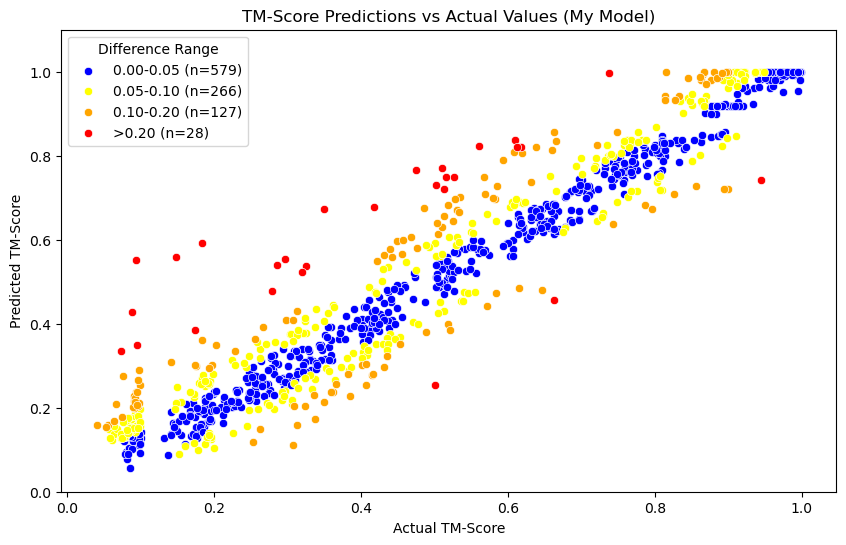

In [5]:
# Add predictions to DataFrame
sequence_df['tm_score_predictions'] = tm_score_predictions

# Calculate the absolute difference between the predicted and actual TM-scores
sequence_df['tm_score_diff'] = abs(sequence_df['tm_score_predictions'] - sequence_df['tm_max'])

# Define colors and labels based on the difference ranges
conditions = [
    (sequence_df['tm_score_diff'] <= 0.05),
    (sequence_df['tm_score_diff'] > 0.05) & (sequence_df['tm_score_diff'] <= 0.10),
    (sequence_df['tm_score_diff'] > 0.10) & (sequence_df['tm_score_diff'] <= 0.20),
    (sequence_df['tm_score_diff'] > 0.2)
]
colors = ['blue', 'yellow', 'orange', 'red']
labels = ['0.00-0.05', '0.05-0.10', '0.10-0.20', '>0.20']
sequence_df['color'] = np.select(conditions, colors)

# Plot the data with labels as intervals
plt.figure(figsize=(10, 6))
for color, label in zip(colors, labels):
    subset = sequence_df[sequence_df['color'] == color]
    sns.scatterplot(x=subset['tm_max'], y=subset['tm_score_predictions'], color=color, label=f'{label} (n={len(subset)})')

plt.xlabel("Actual TM-Score")
plt.ylabel("Predicted TM-Score")
plt.ylim(0, 1.1)  # Set y-axis range from 0 to 1
plt.title("TM-Score Predictions vs Actual Values (My Model)")
plt.legend(title="Difference Range")
plt.show()

In [6]:
print("differences:",differences)

differences: 0.056127491085214636
